Load model from checkpoint

In [1]:
import torch
import os
import random
import yaml as yaml
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
sys.path.append(r"/home/yanmingke/E-Zero/utils")
sys.path.append(r"/home/yanmingke/E-Zero/finetune/models")
from resnet1d import ResNet18
import utils_builder_copy
import torch

device_id = 'cuda'
config = yaml.load(open(r"/home/yanmingke/E-Zero/pretrain/config.yaml", "r"), Loader=yaml.FullLoader)
# 模型权重路径
ckpt_path =r"/data1/1shared/lijun/ecg/E-Zero/checkpoints/resnet-18_new_preprocess_prmopt_0_ckpt.pth"

# 1. 初始化模型结构
# 假设权重对应的是 ResNet-18
model = utils_builder_copy.ECGCLIP(config['network'])
model = torch.nn.DataParallel(model)
# 2. 加载模型权重
checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=True)  # 如果使用 GPU，可将 map_location 设置为 'cuda'
#print(checkpoint)
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict, strict=False)
model = model.to(device_id)
# 3. 切换模型到评估模式
model.eval()

# 打印模型结构以确认加载成功
print(model)


/home/yanmingke/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yanmingke/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:1435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_g

DataParallel(
  (module): ECGCLIP(
    (downconv): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    (att_pool_head): AttentionPool2d(
      (mhsa): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (c_proj): Linear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=256, bias=False)
    (linear2): Linear(in_features=256, out_features=256, bias=False)
    (ecg_encoder): ResNet(
      (conv1): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,

In [2]:
print(checkpoint['model_state_dict'].keys())  # 查看权重文件包含的键值
print(model.state_dict().keys())

odict_keys(['module.downconv.weight', 'module.downconv.bias', 'module.att_pool_head.positional_embedding', 'module.att_pool_head.cls_token', 'module.att_pool_head.mhsa.in_proj_weight', 'module.att_pool_head.mhsa.in_proj_bias', 'module.att_pool_head.mhsa.out_proj.weight', 'module.att_pool_head.mhsa.out_proj.bias', 'module.att_pool_head.c_proj.weight', 'module.att_pool_head.c_proj.bias', 'module.linear1.weight', 'module.linear2.weight', 'module.ecg_encoder.conv1.weight', 'module.ecg_encoder.bn1.weight', 'module.ecg_encoder.bn1.bias', 'module.ecg_encoder.bn1.running_mean', 'module.ecg_encoder.bn1.running_var', 'module.ecg_encoder.bn1.num_batches_tracked', 'module.ecg_encoder.layer1.0.conv1.weight', 'module.ecg_encoder.layer1.0.bn1.weight', 'module.ecg_encoder.layer1.0.bn1.bias', 'module.ecg_encoder.layer1.0.bn1.running_mean', 'module.ecg_encoder.layer1.0.bn1.running_var', 'module.ecg_encoder.layer1.0.bn1.num_batches_tracked', 'module.ecg_encoder.layer1.0.conv2.weight', 'module.ecg_encoder

Open an image and preprocess it

In [3]:
import pandas as pd

# 指定文件路径
file_path = "/data1/1shared/lijun/data/HEEDB/eval.csv"

# 读取 CSV 文件
try:
    data = pd.read_csv(file_path)
    # 展示前几行数据
    print(data.head())
except FileNotFoundError:
    print(f"文件未找到: {file_path}")
except Exception as e:
    print(f"读取 CSV 文件时出错: {e}")


   Unnamed: 0    bdsp_id                                HashFileName  \
0      591183  117585665  de_117585665_20200626132938_20200626174932   
1       72197  120720143  de_120720143_20201129211542_20201204233322   
2       71845  114240753  de_114240753_20200719185231_20200720094147   
3       93288  118205777  de_118205777_20200617124007_20200618125902   
4       71843  114240753  de_114240753_20200718214030_20200719092930   

                                    deid_t_diagnosis  \
0  SINUS RHYTHM|LEFT ATRIAL ENLARGEMENT|WHEN COMP...   
1  SINUS RHYTHM|WITH MARKED SINUS ARRHYTHMIA|RIGH...   
2  NORMAL SINUS RHYTHM|NORMAL ECG|WHEN COMPARED W...   
3                                       SINUS RHYTHM   
4  NORMAL SINUS RHYTHM|NORMAL ECG|WHEN COMPARED W...   

                           deid_t_diagnosis_original  Year  
0  SINUS RHYTHM, CANNOT RULE OUT, ANTERIOR INFARC...  2020  
1  SINUS RHYTHM, WITH MARKED SINUS ARRHYTHMIA, RI...  2020  
2  NORMAL SINUS RHYTHM, NORMAL ECG, WHEN COMPAR

In [4]:
import pandas as pd
import numpy as np
import torch
from scipy.io import loadmat

class SingleECGLoader:
    def __init__(self, mat_path, hea_path, csv_path):
        """
        初始化方法：
        - mat_path: .mat 文件路径
        - hea_path: .hea 文件路径
        - csv_path: 包含注释信息的 CSV 文件路径
        """
        self.mat_path = mat_path
        self.hea_path = hea_path
        self.csv_path = csv_path

    def normalization(self, signal):
        """标准化信号"""
        return (signal - np.mean(signal)) / (np.std(signal) + 1e-8)

    def load_ecg_data(self):
        """加载 ECG 数据和采样率"""
        try:
            # 加载 .mat 文件
            mat_data = loadmat(self.mat_path)
            ecg_data = mat_data['val']  # 获取 ECG 数据
            ecg_data = np.array(ecg_data, dtype=float)  # 转为浮点数组

            # 从 .hea 文件中获取采样率
            with open(self.hea_path, 'r') as hea_file:
                first_line = hea_file.readline().strip()
                elements = first_line.split()
                sample_rate = int(elements[2]) if len(elements) > 2 else 500  # 默认采样率为 500Hz

            # 标准化 ECG 数据
            ecg_data = self.normalization(ecg_data)
            return ecg_data, sample_rate
        except Exception as e:
            print(f"Error loading ECG data: {e}")
            return None, None

    def load_txt_annotation(self):
        """从 CSV 文件中加载注释文本"""
        try:
            data = pd.read_csv(self.csv_path)
            # 筛选与文件名匹配的行
            row = data[data['HashFileName'] == self.mat_path.split('/')[-1].replace('.mat', '')]
            if not row.empty:
                txt_annotation = row.iloc[0]['deid_t_diagnosis_original']
                return txt_annotation
            else:
                print("注释未找到")
                return None
        except Exception as e:
            print(f"Error loading annotation: {e}")
            return None

    def load_data(self):
        """加载 ECG 数据和注释文本"""
        ecg_data, sample_rate = self.load_ecg_data()
        txt_annotation = self.load_txt_annotation()
        return {"ecg": ecg_data, "sample_rate": sample_rate, "txt": txt_annotation}


# 示例代码：读取指定路径和 CSV 中的注释
mat_path = '/data1/1shared/lijun/data/HEEDB/ECG/WFDB/S0001/2018/12/de_118498412_20190407080833_20190409122412.mat'
hea_path = '/data1/1shared/lijun/data/HEEDB/ECG/WFDB/S0001/2018/12/de_118498412_20190407080833_20190409122412.hea'
csv_path = '/data1/1shared/lijun/data/HEEDB/train.csv'

loader = SingleECGLoader(mat_path, hea_path, csv_path)
result = loader.load_data()

# 输出结果
if result:
    print("ECG 数据形状:", result["ecg"].shape if result["ecg"] is not None else "None")
    print("采样率:", result["sample_rate"])
    print("诊断文本:", result["txt"])


ECG 数据形状: (12, 2500)
采样率: 250
诊断文本: NORMAL SINUS RHYTHM, NORMAL ECG, WHEN COMPARED WITH ECG OF, 


In [5]:
device = 'cuda'
image = result["ecg"]
ecg_tensor = torch.tensor(result["ecg"],dtype=torch.float32).unsqueeze(0)
current_length = ecg_tensor.shape[2]  # 当前序列长度
target_length = 5000  # 目标序列长度

# 如果当前长度小于目标长度，则拼接数据
if current_length < target_length:
    repeat_times = (target_length + current_length - 1) // current_length  # 计算需要重复的次数
    ecg_tensor = ecg_tensor.repeat(1, 1, repeat_times)  # 沿时间轴重复数据
    ecg_tensor = ecg_tensor[:, :, :target_length]  # 截取到目标长度

print(f"Expanded ECG shape: {ecg_tensor.shape}") 

# 加载指定路径的图像，并进行预处理以适应模型输入格式

Expanded ECG shape: torch.Size([1, 12, 5000])


Load tokenizer and specify some prompts.

Embed the prompts and the image and compute the cosine similarity between the image and the prompts. Note that for illustrative purposes, we only show image --> text retrieval but the reverse direction is analogous and can be performed using the same function calls. 

In [8]:
# 初始化模型和配置
import torch.nn as nn
# 示例输入数据
device = 'cuda'
ecg_tensor = ecg_tensor.to(device)  # 假设输入是一个样本，12导联，5000时间点
prompts = [ 'NORMAL SINUS RHYTHM, NORMAL ECG, WHEN COMPARED WITH ECG OF', "NORMAL ECG", "SINUS RHYTHM", "LEFT ATRIAL ENLARGEMENT",'photomicrograph illustrating invasive ductal carcinoma of the breast, H&E stain',
           'a case of invasive lobular carcinoma as visualized using H&E stain',
           'high magnification view of a breast cancer tumor, H&E stain',
           'clear cell renal cell carcinoma',
           'lung adenocarcinoma, H&E stain',
           'IHC stain for CDX2 in a case of metastatic colorectal adenocarcinoma',
           'High-grade angiosarcoma characterized by solid areas of polygonal and spindled cells as well as necrosis',
           'metastatic tumor to the lymph node, GATA3 staining',
           'epidermis with follicular ostia']
tokenizer_output = model.module._tokenize(prompts)
input_ids = tokenizer_output['input_ids'].to(device)
attention_mask = tokenizer_output['attention_mask'].to(device)

# 获取嵌入向量并计算相似性
with torch.inference_mode():
    # 获取 ECG 的投影嵌入
    ecg_embedings = model.module.ext_ecg_emb(ecg_tensor)  # 调用模型方法提取 ECG 嵌入
    # 获取文本的投影嵌入
    text_embedings = model.module.get_text_emb(input_ids, attention_mask)
    proj_text_embedings = model.module.proj_t(text_embedings)  # 文本投影层
    proj_text_embedings = nn.functional.normalize(proj_text_embedings, dim=-1)
    proj_ecg_embedings = nn.functional.normalize(ecg_embedings, dim=-1)
    
    # 计算余弦相似性
    sim_scores = (proj_ecg_embedings @ proj_text_embedings.T).squeeze(0)

# 输出按相似性排序的结果
print("Ranked list of prompts based on cosine similarity with the ECG data:")
ranked_scores, ranked_idx = torch.sort(sim_scores, descending=True)
for idx, score in zip(ranked_idx, ranked_scores):
    print(f"\"{prompts[idx]}\": {score:.3f}")


Ranked list of prompts based on cosine similarity with the ECG data:
"NORMAL SINUS RHYTHM, NORMAL ECG, WHEN COMPARED WITH ECG OF": 0.032
"NORMAL ECG": 0.014
"IHC stain for CDX2 in a case of metastatic colorectal adenocarcinoma": -0.004
"SINUS RHYTHM": -0.007
"high magnification view of a breast cancer tumor, H&E stain": -0.046
"epidermis with follicular ostia": -0.117
"photomicrograph illustrating invasive ductal carcinoma of the breast, H&E stain": -0.159
"lung adenocarcinoma, H&E stain": -0.178
"a case of invasive lobular carcinoma as visualized using H&E stain": -0.185
"LEFT ATRIAL ENLARGEMENT": -0.202
"metastatic tumor to the lymph node, GATA3 staining": -0.246
"clear cell renal cell carcinoma": -0.271
"High-grade angiosarcoma characterized by solid areas of polygonal and spindled cells as well as necrosis": -0.335


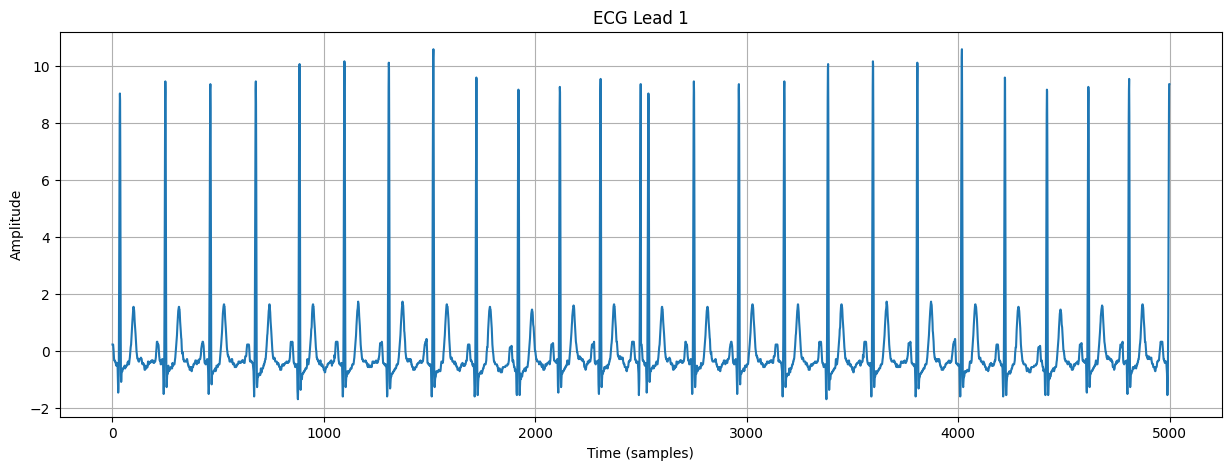

In [7]:
import matplotlib.pyplot as plt

# 假设 ecg_tensor 是 (1, 12, 5000) 的张量
ecg_data = ecg_tensor.squeeze(0)  # 去掉 batch 维度，变为 (12, 5000)

# 绘制第一个导联
lead_idx = 0  # 第 0 个导联
plt.figure(figsize=(15, 5))
plt.plot(ecg_data[lead_idx].cpu().numpy())  # 转为 NumPy 并绘制
plt.title(f"ECG Lead {lead_idx + 1}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


In [ ]:
tokenizer = get_tokenizer()
prompts = [
           'photomicrograph illustrating invasive ductal carcinoma of the breast, H&E stain',
           'a case of invasive lobular carcinoma as visualized using H&E stain',
           'high magnification view of a breast cancer tumor, H&E stain',
           'clear cell renal cell carcinoma',
           'lung adenocarcinoma, H&E stain',
           'IHC stain for CDX2 in a case of metastatic colorectal adenocarcinoma',
           'an image of a cat',
           'High-grade angiosarcoma characterized by solid areas of polygonal and spindled cells as well as necrosis',
           'metastatic tumor to the lymph node, GATA3 staining',
           'epidermis with follicular ostia'
           ]

# 初始化分词器并定义文本提示，用于模型检索任务

In [ ]:
with torch.inference_mode():
    image_embedings = model.encode_image(image_tensor)
    text_embedings = model.encode_text(tokenized_prompts)
    sim_scores = (image_embedings @ text_embedings.T).squeeze(0)

print("Ranked list of prompts based on cosine similarity with the image:")
ranked_scores, ranked_idx = torch.sort(sim_scores, descending=True)
for idx, score in zip(ranked_idx, ranked_scores):
    print(f"\"{prompts[idx]}\": {score:.3f}")

# 使用模型生成图像和文本的嵌入向量，计算余弦相似性并按分数排序

In [ ]:
self.tokenizer = GPT2Tokenizer.from_pretrained('/home/yanmingke/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e')